In [503]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import reservoirpy as rp
from reservoirpy.nodes import Reservoir, Ridge, Input
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
from sklearn.metrics import accuracy_score

In [504]:
def print_shape(x):
    print(x.shape)

In [505]:
df = pd.read_csv('data.csv')

# remove the date column
date_time = df.pop('date')

Y = df.pop('incidents')
X = df


In [506]:
months = pd.to_datetime(date_time, format='%Y-%m-%d').dt.month

In [507]:
df.head()

,"('temperature', 'mean')","('temperature', 'max')","('temperature', 'min')","('humidite', 'mean')","('humidite', 'max')","('humidite', 'min')","('nuages', 'mean')","('nuages', 'max')","('nuages', 'min')"
0,8.407479,10.476465,5.921381,86.976287,96.8684,72.3197,88.009513,100.0,46.87500
1,10.482559,13.003564,8.543604,89.939588,96.2094,81.1347,91.015629,100.0,35.93750
2,10.108455,12.519678,8.909326,94.035604,97.8528,89.3497,95.084633,100.0,67.18750
3,8.958734,12.460107,5.731348,86.352908,92.5699,68.4599,73.518883,100.0,0.00000
4,7.104425,8.300439,5.926172,90.596867,96.4792,78.9225,66.927081,100.0,5.46875


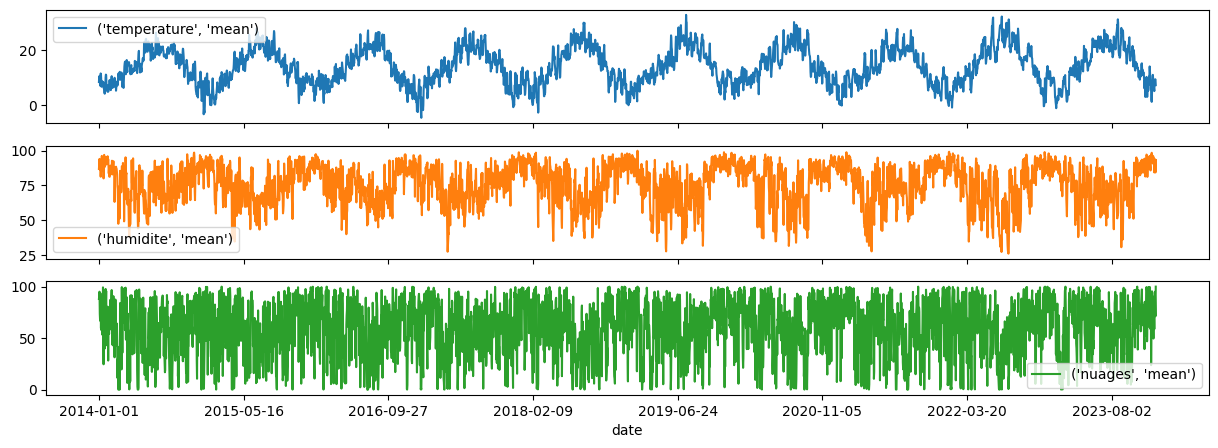

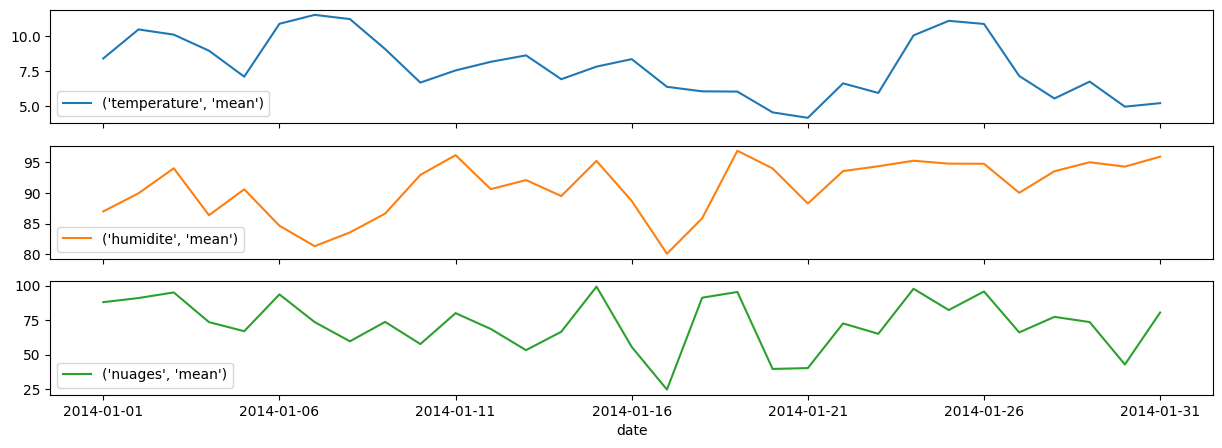

In [508]:

plot_cols = ["('temperature', 'mean')", "('humidite', 'mean')", "('nuages', 'mean')"]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(15, 5))

plot_features = df[plot_cols][:31]
plot_features.index = date_time[:31]
_ = plot_features.plot(subplots=True, figsize=(15, 5))

In [509]:
# split train and test (test = last 300 days, train = rest)
# X = ('temperature', 'mean')	('temperature', 'max')	('temperature', 'min')	('humidite', 'mean')	('humidite', 'max')	('humidite', 'min')	('nuages', 'mean')	('nuages', 'max')	('nuages', 'min')
# Y = incidents (0 or 1 or 2)
train_df = df[:-300]
test_df = df[-300:]
train_labels = Y[:-300]
test_labels = Y[-300:]

# normalize data
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_data = np.array(train_df)
train_labels = np.array(train_labels)
test_data = np.array(test_df)
test_labels = np.array(test_labels)
# transform labels to one hot
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)


(3353, 9)
(3353, 3)
(300, 9)
(300, 3)


In [510]:
def get_periods_indices(months, start_month, end_month, test=False):
    if test is False:
        return [
            index for index in range(len(months))
            if months[index] > start_month and months[index] < end_month and index < (len(months) - 300)
        ]
    else :
        return [
            index for index in range(len(months))
            if months[index] > start_month and months[index] < end_month >= (len(months) - 300)
        ][-300:]

In [511]:
# create a model to predict if today is a risky day, very risky day or not (0, 1, 2) using reservoirpy

# create a reservoir
source = Input()
reservoir = Reservoir(500, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-2)



train_states = reservoir.run(train_data)

# Get the indices of the summer months
summer_periods_indices_train = [
            index for index in range(len(months))
            if months[index] > 4 and months[index] < 9 and index < (len(months) - 300)
        ]
summer_periods_indices_test = [
            index for index in range(len(months))
            if months[index] > 4 and months[index] < 9 and index >= (len(months) - 300)
        ][-300:]

train_states_filtered = train_states[summer_periods_indices_train]
train_labels_filtered = train_labels[summer_periods_indices_train]

readout.fit(train_states_filtered, train_labels_filtered)

Running Reservoir-43:   0%|          | 0/3353 [00:00<?, ?it/s]

Running Reservoir-43: 100%|██████████| 3353/3353 [00:00<00:00, 13291.48it/s]


'Ridge-43': Ridge(ridge=0.01, input_bias=True, in=500, out=3)

In [512]:
summer_periods_indices_test = np.array(summer_periods_indices_test) - (len(months) - 300) 


In [513]:
Y_pred = readout.run(reservoir.run(test_data))
print(test_data.shape)
print(Y_pred.shape)

Running Ridge-43: 100%|██████████| 300/300 [00:00<00:00, 40514.24it/s]

(300, 9)
(300, 3)


In [514]:
Y_pred_filtered = Y_pred[summer_periods_indices_test]
test_filtered_labels = test_labels[summer_periods_indices_test]

In [515]:
Y_pred_filtered

array([[ 1.79409244e+00, -1.52358210e-01, -6.42696734e-01],
       [ 1.88264453e+00, -2.89999822e-01, -5.93000932e-01],
       [ 1.93088466e+00, -3.10133554e-01, -6.21187398e-01],
       [ 2.05183829e+00, -3.98801801e-01, -6.53747138e-01],
       [ 2.13318210e+00, -5.17670585e-01, -6.15486376e-01],
       [ 2.21475387e+00, -5.86723260e-01, -6.27652759e-01],
       [ 2.12087493e+00, -5.15585362e-01, -6.04603379e-01],
       [ 2.05467599e+00, -3.93789134e-01, -6.60380233e-01],
       [ 2.06498080e+00, -3.75990996e-01, -6.88505654e-01],
       [ 2.24880907e+00, -5.38363529e-01, -7.09272198e-01],
       [ 2.21753591e+00, -5.08610933e-01, -7.07154131e-01],
       [ 2.21033487e+00, -5.04619220e-01, -7.03830412e-01],
       [ 2.19898016e+00, -5.21428682e-01, -6.75045181e-01],
       [ 2.19882197e+00, -5.27630329e-01, -6.68152002e-01],
       [ 2.09197901e+00, -4.18910834e-01, -6.69146736e-01],
       [ 2.04220744e+00, -3.84569400e-01, -6.53543444e-01],
       [ 1.99322192e+00, -3.48166022e-01

In [516]:
# model = [source >> reservoir, source] >> readout
# Y_pred_2 = model.fit(train_states_filtered, train_labels_filtered, stateful=False).run(test_data, stateful=False)

In [517]:
print(train_states_filtered.shape)
print_shape(test_data)

(1107, 500)
(300, 9)


In [518]:
Y_pred_class = [np.argmax(y_p) for y_p in Y_pred_filtered]
Y_test_class = [np.argmax(y_t) for y_t in test_filtered_labels]

score = accuracy_score((Y_test_class), (Y_pred_class))

print("Accuracy: ", f"{score * 100:.3f} %")

Accuracy:  68.293 %


In [524]:
print(f"Y pred class:\n0 count : {Y_pred_class.count(0)}\n1 count : {Y_pred_class.count(1)}\n2 count : {Y_pred_class.count(2)}")

Y pred class:
0 count : 86
1 count : 21
2 count : 16


In [519]:
# plt.figure(figsize=(15,5))
# import confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(Y_pred_class, Y_test_class)

array([[78,  7,  1],
       [16,  3,  2],
       [ 9,  4,  3]])